In [1]:
import sagemaker
from sagemaker import get_execution_role
import torch
import torch.nn as nn
import torch.functional as f
import torch.optim as optim
import pandas as pd
from torch.utils.data import random_split, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
#Read and split dataset
bucket = 'sagemaker-ann-fyp'
data_key = 'complete_dataset.csv' 
travel_data = 's3://{}/{}'.format(bucket,data_key)

full_dataset = pd.read_csv(travel_data)

dataset_features = ['hod','sourcelong','sourcelat','dstlong','dstlat','distance']
X = full_dataset[dataset_features]
y = full_dataset['mean_travel_time']

train_X, test_X, train_y, test_y = train_test_split(X,y,random_state=0)

train_X = torch.FloatTensor(train_X.values)
test_X = torch.FloatTensor(test_X.values)

train_y = torch.FloatTensor(train_y.values)
test_y = torch.FloatTensor(test_y.values)

print(train_X)

tensor([[ 1.2000e+01, -3.1432e-01,  5.1517e+01, -2.6322e-01,  5.1623e+01,
          1.8053e+04],
        [ 1.5000e+01, -9.4330e-02,  5.1318e+01, -1.0651e-01,  5.1388e+01,
          9.7661e+03],
        [ 1.8000e+01, -4.6590e-02,  5.1419e+01, -1.3372e-01,  5.1398e+01,
          8.8624e+03],
        ...,
        [ 1.3000e+01, -3.1403e-01,  5.1505e+01, -1.9315e-01,  5.1521e+01,
          1.2252e+04],
        [ 7.0000e+00, -2.3532e-01,  5.1397e+01, -2.7983e-01,  5.1389e+01,
          5.5678e+03],
        [ 0.0000e+00, -1.5530e-01,  5.1339e+01, -1.6564e-01,  5.1396e+01,
          7.4586e+03]])


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#Custom Data loaders
train_data = TensorDataset(train_X,train_y)
test_data = TensorDataset(test_X,test_y)

batch_size = 200

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

#print(next(iter(train_loader)))

In [5]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super(MLP, self).__init__()
        
        assert out_dim==1, 'out_dim must be 1'
        
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.linear1 = nn.Linear(self.in_dim, self.hidden_dim[0])
        self.linear2 = nn.Linear(self.hidden_dim[0], self.hidden_dim[1])
        self.linear3 = nn.Linear(self.hidden_dim[1], self.hidden_dim[2])
        self.linear4 = nn.Linear(self.hidden_dim[2], self.hidden_dim[3])
        self.linear5 = nn.Linear(self.hidden_dim[3], self.hidden_dim[4])
        self.linear6 = nn.Linear(self.hidden_dim[4], self.hidden_dim[5])
        self.linear7 = nn.Linear(self.hidden_dim[5], self.out_dim)
    
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = torch.relu(self.linear3(x))
        x = torch.relu(self.linear4(x))
        x = torch.relu(self.linear5(x))
        x = torch.relu(self.linear6(x))
        x = self.linear7(x)
        x = x.squeeze(1)
        return x

In [6]:
def mae_loss(y_pred, y_true):
    mae = torch.abs(y_true - y_pred).mean()
    return mae

In [7]:
mlp = MLP(train_X.shape[1], [16,12,10,8,6,4], 1).to(device)
optimizer = optim.Adam(mlp.parameters())

In [8]:
#training phase
epochs = 1000
#to plot loss curve after training
valid_losses = []

for epoch in range(epochs):
    start_time = time.time()
    mlp.train()
    num_batch = train_X.shape[0] // 200 + 1
    
    for batch_id, (batch_x, batch_y) in enumerate(train_loader):
        y_pred = mlp(batch_x)

        loss = mae_loss(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        elapsed_min = int(elapsed_time / 60)
        elapsed_sec = elapsed_time - 60 * elapsed_min

        print('\rEpoch:{} Batch:{}/{} Loss:{:.4f} Time:{}m{:.2f}s'.format(epoch + 1, batch_id, 
                                                                          num_batch, loss.item(),
                                                                          elapsed_min, elapsed_sec), end='')
    print()
    mlp.eval()
    valid_loss = 0
    best_loss = np.inf
    num_batch = train_y.shape[0] // 200 + 1
    
    for batch_id, (batch_x, batch_y) in enumerate(test_loader):
    
        y_pred = mlp(batch_x)
        loss = mae_loss(y_pred, batch_y)
        valid_loss += loss.item()
    
    valid_loss /= num_batch
    valid_losses.append(valid_loss)
    
    #save model when validation loss is minimum
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(mlp.state_dict(), 'mlp.model')  
    
    print('Valid Loss:{:.4f}'.format(valid_loss))

Epoch:1 Batch:561/562 Loss:440.8409 Time:0m2.78s
Valid Loss:155.6885
Epoch:2 Batch:561/562 Loss:440.2438 Time:0m2.18s
Valid Loss:154.4286
Epoch:3 Batch:561/562 Loss:428.0855 Time:0m2.19s
Valid Loss:153.6470
Epoch:4 Batch:561/562 Loss:478.1778 Time:0m2.17s
Valid Loss:152.7064
Epoch:5 Batch:561/562 Loss:445.0477 Time:0m2.16s
Valid Loss:151.6428
Epoch:6 Batch:561/562 Loss:430.2256 Time:0m2.05s
Valid Loss:149.3358
Epoch:7 Batch:561/562 Loss:430.5264 Time:0m2.07s
Valid Loss:141.7096
Epoch:8 Batch:561/562 Loss:378.1218 Time:0m2.08s
Valid Loss:139.1391
Epoch:9 Batch:561/562 Loss:451.9034 Time:0m2.14s
Valid Loss:139.1551
Epoch:10 Batch:561/562 Loss:453.6658 Time:0m2.26s
Valid Loss:138.3396
Epoch:11 Batch:561/562 Loss:418.8062 Time:0m2.15s
Valid Loss:138.2406
Epoch:12 Batch:561/562 Loss:433.8280 Time:0m2.13s
Valid Loss:138.4067
Epoch:13 Batch:561/562 Loss:422.1270 Time:0m2.19s
Valid Loss:137.9743
Epoch:14 Batch:561/562 Loss:416.8501 Time:0m2.16s
Valid Loss:137.9382
Epoch:15 Batch:561/562 Loss:4

Epoch:118 Batch:561/562 Loss:345.3552 Time:0m2.18s
Valid Loss:123.2723
Epoch:119 Batch:561/562 Loss:349.7225 Time:0m2.18s
Valid Loss:122.9971
Epoch:120 Batch:561/562 Loss:415.4013 Time:0m2.26s
Valid Loss:121.9935
Epoch:121 Batch:561/562 Loss:348.5866 Time:0m2.30s
Valid Loss:121.6599
Epoch:122 Batch:561/562 Loss:353.1442 Time:0m2.12s
Valid Loss:121.5542
Epoch:123 Batch:561/562 Loss:342.8033 Time:0m2.15s
Valid Loss:122.2965
Epoch:124 Batch:561/562 Loss:390.8510 Time:0m2.06s
Valid Loss:120.3737
Epoch:125 Batch:561/562 Loss:329.5586 Time:0m2.07s
Valid Loss:120.0609
Epoch:126 Batch:561/562 Loss:310.0344 Time:0m2.08s
Valid Loss:120.4557
Epoch:127 Batch:561/562 Loss:357.8741 Time:0m2.14s
Valid Loss:120.3028
Epoch:128 Batch:561/562 Loss:362.8196 Time:0m2.17s
Valid Loss:120.0278
Epoch:129 Batch:561/562 Loss:373.8160 Time:0m2.15s
Valid Loss:120.3590
Epoch:130 Batch:561/562 Loss:356.9471 Time:0m2.17s
Valid Loss:120.5294
Epoch:131 Batch:561/562 Loss:393.1266 Time:0m2.15s
Valid Loss:123.6305
Epoch:

Epoch:233 Batch:561/562 Loss:329.8107 Time:0m2.15s
Valid Loss:118.4347
Epoch:234 Batch:561/562 Loss:375.4267 Time:0m2.10s
Valid Loss:118.4872
Epoch:235 Batch:561/562 Loss:350.2556 Time:0m2.19s
Valid Loss:118.3586
Epoch:236 Batch:561/562 Loss:316.9231 Time:0m2.28s
Valid Loss:118.1492
Epoch:237 Batch:561/562 Loss:351.5785 Time:0m2.20s
Valid Loss:118.1792
Epoch:238 Batch:561/562 Loss:376.2155 Time:0m2.35s
Valid Loss:118.5919
Epoch:239 Batch:561/562 Loss:344.6916 Time:0m2.41s
Valid Loss:118.3109
Epoch:240 Batch:561/562 Loss:388.6925 Time:0m2.26s
Valid Loss:118.2166
Epoch:241 Batch:561/562 Loss:355.8792 Time:0m2.10s
Valid Loss:118.3795
Epoch:242 Batch:561/562 Loss:306.9700 Time:0m2.09s
Valid Loss:118.1871
Epoch:243 Batch:561/562 Loss:415.0012 Time:0m2.08s
Valid Loss:118.2233
Epoch:244 Batch:561/562 Loss:415.7870 Time:0m2.20s
Valid Loss:118.7920
Epoch:245 Batch:561/562 Loss:378.4551 Time:0m2.25s
Valid Loss:122.2993
Epoch:246 Batch:561/562 Loss:397.1692 Time:0m2.16s
Valid Loss:123.6327
Epoch:

Epoch:348 Batch:561/562 Loss:350.2792 Time:0m2.23s
Valid Loss:119.6346
Epoch:349 Batch:561/562 Loss:421.4353 Time:0m2.14s
Valid Loss:121.0281
Epoch:350 Batch:561/562 Loss:362.8440 Time:0m2.09s
Valid Loss:118.7987
Epoch:351 Batch:561/562 Loss:399.8052 Time:0m2.17s
Valid Loss:120.1027
Epoch:352 Batch:561/562 Loss:371.3186 Time:0m2.57s
Valid Loss:118.3729
Epoch:353 Batch:561/562 Loss:375.2506 Time:0m2.74s
Valid Loss:121.0962
Epoch:354 Batch:561/562 Loss:346.7878 Time:0m2.26s
Valid Loss:119.7167
Epoch:355 Batch:561/562 Loss:355.5807 Time:0m2.27s
Valid Loss:117.7866
Epoch:356 Batch:561/562 Loss:358.6373 Time:0m2.16s
Valid Loss:119.7676
Epoch:357 Batch:561/562 Loss:391.9679 Time:0m2.23s
Valid Loss:119.0033
Epoch:358 Batch:561/562 Loss:383.1364 Time:0m2.13s
Valid Loss:118.2082
Epoch:359 Batch:561/562 Loss:352.6465 Time:0m2.16s
Valid Loss:122.3750
Epoch:360 Batch:561/562 Loss:388.6212 Time:0m2.07s
Valid Loss:118.1112
Epoch:361 Batch:561/562 Loss:299.6241 Time:0m2.07s
Valid Loss:118.9095
Epoch:

Epoch:463 Batch:561/562 Loss:352.6159 Time:0m2.18s
Valid Loss:117.8320
Epoch:464 Batch:561/562 Loss:349.0847 Time:0m2.24s
Valid Loss:118.4320
Epoch:465 Batch:561/562 Loss:347.6516 Time:0m2.15s
Valid Loss:118.3018
Epoch:466 Batch:561/562 Loss:396.5672 Time:0m2.18s
Valid Loss:117.8881
Epoch:467 Batch:561/562 Loss:330.6750 Time:0m2.14s
Valid Loss:119.4261
Epoch:468 Batch:561/562 Loss:361.6996 Time:0m2.13s
Valid Loss:118.3162
Epoch:469 Batch:561/562 Loss:350.8634 Time:0m2.09s
Valid Loss:118.4392
Epoch:470 Batch:561/562 Loss:387.0701 Time:0m2.20s
Valid Loss:118.6825
Epoch:471 Batch:561/562 Loss:333.3457 Time:0m2.23s
Valid Loss:118.0792
Epoch:472 Batch:561/562 Loss:366.4445 Time:0m2.21s
Valid Loss:118.4578
Epoch:473 Batch:561/562 Loss:369.1792 Time:0m2.17s
Valid Loss:118.6337
Epoch:474 Batch:561/562 Loss:342.2844 Time:0m2.20s
Valid Loss:117.6495
Epoch:475 Batch:561/562 Loss:362.3962 Time:0m2.21s
Valid Loss:119.1881
Epoch:476 Batch:561/562 Loss:361.4500 Time:0m2.33s
Valid Loss:118.0341
Epoch:

Epoch:578 Batch:561/562 Loss:369.5220 Time:0m2.11s
Valid Loss:117.5452
Epoch:579 Batch:561/562 Loss:359.2120 Time:0m2.15s
Valid Loss:117.2389
Epoch:580 Batch:561/562 Loss:373.5249 Time:0m2.18s
Valid Loss:118.7120
Epoch:581 Batch:561/562 Loss:311.5359 Time:0m2.22s
Valid Loss:118.4333
Epoch:582 Batch:561/562 Loss:326.3431 Time:0m2.16s
Valid Loss:117.3938
Epoch:583 Batch:561/562 Loss:331.4205 Time:0m2.17s
Valid Loss:117.0654
Epoch:584 Batch:561/562 Loss:340.0155 Time:0m2.26s
Valid Loss:117.8450
Epoch:585 Batch:561/562 Loss:351.3190 Time:0m2.14s
Valid Loss:117.5561
Epoch:586 Batch:561/562 Loss:332.0148 Time:0m2.10s
Valid Loss:119.8705
Epoch:587 Batch:561/562 Loss:367.2968 Time:0m2.12s
Valid Loss:117.1372
Epoch:588 Batch:561/562 Loss:358.7549 Time:0m2.25s
Valid Loss:118.3767
Epoch:589 Batch:561/562 Loss:317.5941 Time:0m2.21s
Valid Loss:117.1146
Epoch:590 Batch:561/562 Loss:356.2838 Time:0m2.28s
Valid Loss:117.0456
Epoch:591 Batch:561/562 Loss:325.8082 Time:0m2.22s
Valid Loss:117.0789
Epoch:

Epoch:693 Batch:561/562 Loss:275.7199 Time:0m2.35s
Valid Loss:106.6816
Epoch:694 Batch:561/562 Loss:332.2271 Time:0m2.23s
Valid Loss:108.3195
Epoch:695 Batch:561/562 Loss:309.3564 Time:0m2.07s
Valid Loss:106.5031
Epoch:696 Batch:561/562 Loss:323.2487 Time:0m2.12s
Valid Loss:106.8220
Epoch:697 Batch:561/562 Loss:330.8205 Time:0m2.19s
Valid Loss:105.6538
Epoch:698 Batch:561/562 Loss:350.0057 Time:0m2.19s
Valid Loss:106.2727
Epoch:699 Batch:561/562 Loss:300.2570 Time:0m2.18s
Valid Loss:109.7675
Epoch:700 Batch:561/562 Loss:332.1009 Time:0m2.16s
Valid Loss:104.8162
Epoch:701 Batch:561/562 Loss:338.6137 Time:0m2.29s
Valid Loss:103.8208
Epoch:702 Batch:561/562 Loss:338.7157 Time:0m2.94s
Valid Loss:105.7925
Epoch:703 Batch:561/562 Loss:337.5076 Time:0m2.14s
Valid Loss:105.3319
Epoch:704 Batch:561/562 Loss:312.8255 Time:0m2.12s
Valid Loss:105.9096
Epoch:705 Batch:561/562 Loss:308.6894 Time:0m2.13s
Valid Loss:105.8906
Epoch:706 Batch:561/562 Loss:309.0624 Time:0m2.17s
Valid Loss:106.0874
Epoch:

Epoch:808 Batch:561/562 Loss:286.3774 Time:0m2.47s
Valid Loss:106.4912
Epoch:809 Batch:561/562 Loss:314.6305 Time:0m2.36s
Valid Loss:99.6601
Epoch:810 Batch:561/562 Loss:277.3036 Time:0m2.31s
Valid Loss:101.5529
Epoch:811 Batch:561/562 Loss:301.8257 Time:0m2.47s
Valid Loss:99.1828
Epoch:812 Batch:561/562 Loss:301.5793 Time:0m2.43s
Valid Loss:100.1635
Epoch:813 Batch:561/562 Loss:283.2946 Time:0m2.47s
Valid Loss:101.8015
Epoch:814 Batch:561/562 Loss:345.3141 Time:0m2.61s
Valid Loss:106.4199
Epoch:815 Batch:561/562 Loss:288.8192 Time:0m2.69s
Valid Loss:104.1141
Epoch:816 Batch:561/562 Loss:317.4752 Time:0m2.50s
Valid Loss:103.7033
Epoch:817 Batch:561/562 Loss:239.9415 Time:0m2.49s
Valid Loss:102.6934
Epoch:818 Batch:561/562 Loss:301.6223 Time:0m2.43s
Valid Loss:103.4040
Epoch:819 Batch:561/562 Loss:303.6926 Time:0m2.47s
Valid Loss:101.7165
Epoch:820 Batch:561/562 Loss:325.3988 Time:0m2.41s
Valid Loss:100.0463
Epoch:821 Batch:561/562 Loss:279.6426 Time:0m2.57s
Valid Loss:100.6830
Epoch:82

Epoch:924 Batch:561/562 Loss:300.6747 Time:0m2.19s
Valid Loss:98.8947
Epoch:925 Batch:561/562 Loss:319.0045 Time:0m2.18s
Valid Loss:99.6983
Epoch:926 Batch:561/562 Loss:336.8220 Time:0m2.22s
Valid Loss:99.3635
Epoch:927 Batch:561/562 Loss:266.5500 Time:0m2.17s
Valid Loss:100.3335
Epoch:928 Batch:561/562 Loss:254.0180 Time:0m2.15s
Valid Loss:101.3967
Epoch:929 Batch:561/562 Loss:304.3264 Time:0m2.10s
Valid Loss:101.6577
Epoch:930 Batch:561/562 Loss:255.2129 Time:0m2.08s
Valid Loss:98.6271
Epoch:931 Batch:561/562 Loss:248.4775 Time:0m2.06s
Valid Loss:98.4903
Epoch:932 Batch:561/562 Loss:291.4393 Time:0m2.15s
Valid Loss:100.9054
Epoch:933 Batch:561/562 Loss:339.6170 Time:0m2.16s
Valid Loss:98.3450
Epoch:934 Batch:561/562 Loss:274.1879 Time:0m2.13s
Valid Loss:100.1388
Epoch:935 Batch:561/562 Loss:323.6929 Time:0m2.14s
Valid Loss:102.5057
Epoch:936 Batch:561/562 Loss:312.1075 Time:0m2.18s
Valid Loss:103.2510
Epoch:937 Batch:561/562 Loss:291.6154 Time:0m2.18s
Valid Loss:99.5277
Epoch:938 Bat

minimum validation loss is 97.7376


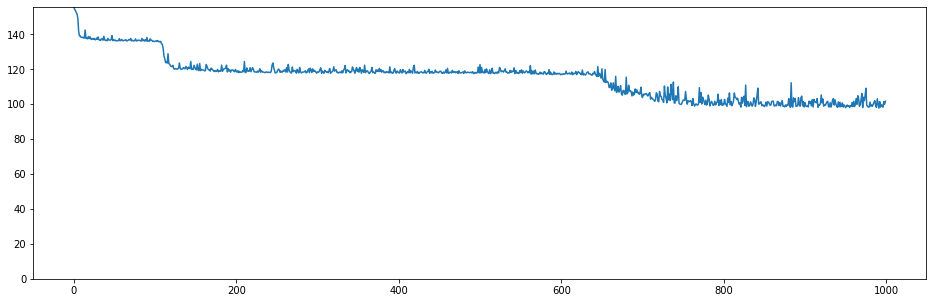

In [9]:
#plot validation loss curve, this may help to notice overfitting
plt.figure(figsize=(16,5))
plt.ylim(0,max(valid_losses)+0.02)
plt.plot(valid_losses)
print('minimum validation loss is {:.4f}'.format(min(valid_losses)))

In [10]:
x_test = np.array([[6,0.031180191,51.51122955,-0.044059634,51.54066292,9681]])
input_test = torch.tensor(x_test, dtype=torch.float, device=device )

mlp.load_state_dict(torch.load('mlp.model'))
y_pred = mlp(input_test)
y_pred = y_pred.data.cpu().numpy()
print(y_pred)
#Expected reading should be 911.37

[1189.8688]
